<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/DeepWalk/DeepWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 유저와 영화를 노드로 가진 이분 그래프로 데이터를 표현
- 영화 -> 유저 -> 영화 식으로 randomwalk를 진행하여 영화를 임베딩하는 것이 목표
- 각 영화 별로 32 ~ 64개 정도의 random walk를 진행(영화만 list에 포함)
- walk의 길이는 40
- 따라서 영화 1개당 32 ~ 64 개의 node list가 생기고, 각 list의 길이는 40이됨

In [1]:
import os
from tqdm import tqdm
from collections import defaultdict

import random
import numpy as np
import pandas as pd

import warnings

warnings.filterwarnings(action='ignore')

In [2]:
class Config:
    data_path = '/content/drive/MyDrive/RecsysTutorial/Data/MovieLens' # 데이터 경로
    model_path = '/content/drive/MyDrive/RecsysTutorial/Model/'
    model_name = 'DeepWalk'
    num_walks = 64
    walk_length = 40
    embedding_size = 64
    epochs = 300

config = Config()

In [3]:
ratings = pd.read_csv(os.path.join(config.data_path, 'ratings.csv'))
ratings = ratings.sort_values(['userId', 'timestamp']).reset_index(drop = True)
ratings['userId'] = ratings['userId'].astype(str)
ratings['movieId'] = ratings['movieId'].astype(str)

movies = pd.read_csv(os.path.join(config.data_path, 'movies.csv'))
movies['movieId'] = movies['movieId'].astype(str)

In [4]:
def get_A_to_B(df : pd.DataFrame, A : str, B : str):
    A_to_B = {}
    A_group_df = ratings.groupby(A)
    for A_id, A_g_d in A_group_df:
        A_to_B[A_id] = A_g_d[B].tolist()
    
    return A_to_B

movie_to_user = get_A_to_B(df = ratings, A = 'movieId', B = 'userId')
user_to_movie = get_A_to_B(df = ratings, A = 'userId', B = 'movieId')

In [5]:
def random_walk(num_walks : int, walk_length : int, node_list : list, node_to_edge : dict, edge_to_node : dict):
    walks = []
    for init_node in tqdm(node_list):
        for _ in range(num_walks):
            walk = []
            walk += [init_node]
            while len(walk) < walk_length:
                start_node = walk[-1]
                edge = random.choice(node_to_edge[start_node])
                end_node = random.choice(edge_to_node[edge])
                walk += [end_node]
            
            walks.append(walk)

    return walks

In [6]:
node_list = list(movie_to_user.keys())

random_walks = random_walk(num_walks = config.num_walks, walk_length = config.walk_length, node_list = node_list, node_to_edge = movie_to_user, edge_to_node = user_to_movie)

100%|██████████| 9066/9066 [01:37<00:00, 92.82it/s] 


In [7]:
!pip install gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import datetime

class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 1
        self.loss_to_be_subed = 0
        self.loss_now = 987654321

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed

        self.loss_to_be_subed = loss

        if loss_now < self.loss_now:
            self.loss_now = loss_now
            model.save(os.path.join(config.model_path, config.model_name + '.model'))
            print(f'Loss after epoch {self.epoch}: {loss_now}')
            print('Model 저장')
        self.epoch += 1

start = datetime.datetime.now()

model = Word2Vec(
                sentences = random_walks,
                seed = 22,
                epochs = config.epochs,
                min_count = 1,
                vector_size = config.embedding_size,
                sg = 0, # 원래는 skip-gram으로 학습해야 하지만, 속도 이슈가 있어서 CBOW로 학습함
                window = config.walk_length,
                compute_loss = True,
                callbacks=[callback()],
                 )

print("Time passed: " + str(datetime.datetime.now() - start))

In [10]:
from gensim.models import Word2Vec

deepwalk = Word2Vec.load(os.path.join(config.model_path, config.model_name + '.model'))

vectors = []
for node in node_list:
    vectors.append(deepwalk.wv[node])
vectors = np.array(vectors)

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(vectors)

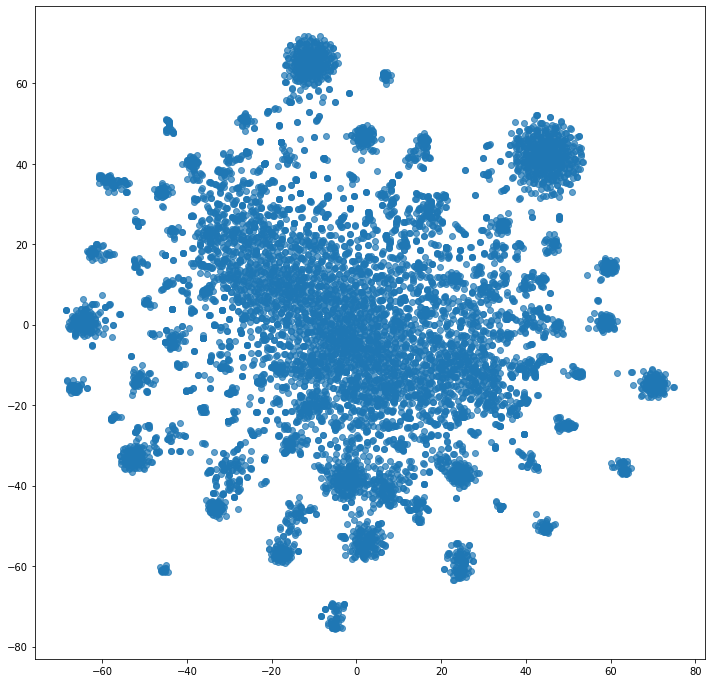

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(x = tsne_vectors[:, 0], y = tsne_vectors[:, 1], alpha = 0.7)
plt.show()

In [16]:
node_to_idx = {}
idx_to_node = {}

for idx, node in enumerate(node_list):
    node_to_idx[node] = idx
    idx_to_node[idx] = node

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

sim_vector = cosine_similarity(vectors[[node_to_idx['162672']]], vectors)[0]
rec_list = np.argsort(sim_vector)[::-1][:11]
rec_list = [idx_to_node[rec] for rec in rec_list]
movies.set_index('movieId').loc[rec_list, :]

,title,genres
movieId,,
162672,Mohenjo Daro (2016),Adventure|Drama|Romance
162542,Rustom (2016),Romance|Thriller
108514,Yeh Jawaani Hai Deewani (2013),Comedy|Drama|Musical|Romance
98000,Student of the Year (2012),Comedy|Romance
149606,Bajirao Mastani (2015),Romance|War
150548,Sherlock: The Abominable Bride (2016),Action|Crime|Drama|Mystery|Thriller
73290,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,Drama
105504,Captain Phillips (2013),Adventure|Drama|Thriller|IMAX
8985,Blade: Trinity (2004),Action|Fantasy|Horror|Thriller


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

sim_vector = cosine_similarity(vectors[[node_to_idx['1']]], vectors)[0]
rec_list = np.argsort(sim_vector)[::-1][:11]
rec_list = [idx_to_node[rec] for rec in rec_list]
movies.set_index('movieId').loc[rec_list, :]

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
832,Ransom (1996),Crime|Thriller
494,Executive Decision (1996),Action|Adventure|Thriller
376,"River Wild, The (1994)",Action|Thriller
784,"Cable Guy, The (1996)",Comedy|Thriller
3,Grumpier Old Men (1995),Comedy|Romance
1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
6,Heat (1995),Action|Crime|Thriller


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

sim_vector = cosine_similarity(vectors[[node_to_idx['4774']]], vectors)[0]
rec_list = np.argsort(sim_vector)[::-1][:11]
rec_list = [idx_to_node[rec] for rec in rec_list]
movies.set_index('movieId').loc[rec_list, :]

,title,genres
movieId,,
4774,Big Trouble (2002),Comedy|Crime
32381,Bells Are Ringing (1960),Comedy|Musical|Romance
8986,"Bellboy, The (1960)",Comedy
9000,That's Entertainment! III (1994),Documentary
8988,Cinderfella (1960),Comedy
6703,"Order, The (2003)",Horror|Mystery|Thriller
3612,The Slipper and the Rose: The Story of Cindere...,Adventure|Children|Fantasy|Musical|Romance
6536,Sinbad: Legend of the Seven Seas (2003),Adventure|Animation|Children|Fantasy
4818,Extreme Days (2001),Action|Adventure|Comedy|Drama


In [46]:
from sklearn.metrics.pairwise import cosine_similarity

sim_vector = cosine_similarity(vectors[[node_to_idx['3936']]], vectors)[0]
rec_list = np.argsort(sim_vector)[::-1][:11]
rec_list = [idx_to_node[rec] for rec in rec_list]
movies.set_index('movieId').loc[rec_list, :]

,title,genres
movieId,,
3936,Phantom of the Opera (1943),Horror|Musical|Thriller
5395,"Gambler, The (1974)",Drama
617,"Flower of My Secret, The (La flor de mi secret...",Comedy|Drama
5427,Caveman (1981),Comedy
3303,Black Tar Heroin: The Dark End of the Street (...,Documentary
5224,Promises (2001),Documentary
4076,Two Ninas (1999),Comedy|Romance
2238,Seven Beauties (Pasqualino Settebellezze) (1976),Comedy|Drama
5202,Mon oncle d'Amérique (1980),Drama
